In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/data_cleaned")

In [3]:
df.columns

Index(['Unnamed: 0', 'track_id', 'track_name', 'track_artist',
       'track_popularity', 'track_album_id', 'track_album_name',
       'track_album_release_date', 'playlist_name', 'playlist_id',
       'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')

We want to use 'danceability' and 'energy' to create a party playlist. 

In [4]:
df[['danceability', 'energy']].describe()

,danceability,energy
count,28356.000000,28356.000000
mean,0.653372,0.698388
std,0.145785,0.183503
min,0.000000,0.000175
25%,0.561000,0.579000
50%,0.670000,0.722000
75%,0.760000,0.843000
max,0.983000,1.000000


For this create a new variable "party_score" by projection onto a line (other options possible - e.g. project onto circle to emphasize one of the features etc):

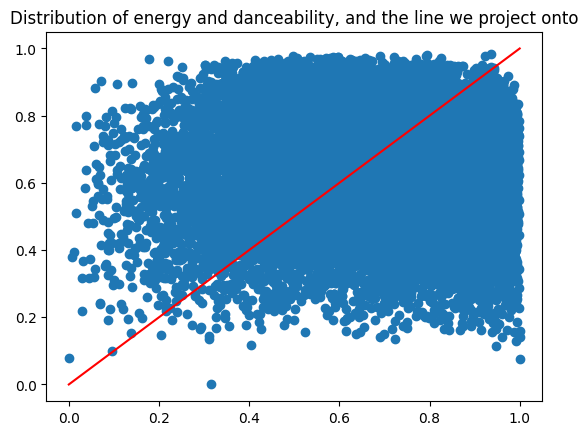

In [6]:
plt.scatter(df.energy,df.danceability)
plt.plot((0,1),(0,1),c = "red")
plt.title("Distribution of energy and danceability, and the line we project onto")
plt.show()

In [7]:
# take two-dimensional variable (x,y)

x = df.energy
y = df.danceability

# project onto line x=y

x_p = (x + y) / 2
y_p = (x + y) / 2

# take length of the vector (x_p,y_p) as new variable

z = pd.DataFrame(np.sqrt(x_p**2 + y_p**2))

# and normalize 

from sklearn.preprocessing import MinMaxScaler
df["party_score"] = MinMaxScaler().fit_transform(z)

<AxesSubplot:ylabel='Count'>

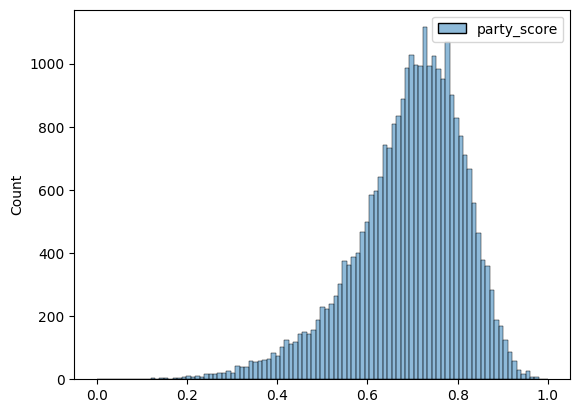

In [8]:
sns.histplot(df[["party_score"]])

Given a (random) list of $n=50$ songs, let's arrange a playlist:

In [9]:
n = 50
track_list = df[["party_score"]].sample(n)

In [10]:
#extract two minima (will be start and end song) and remove from track list

min1_idx = track_list.idxmin()
start_song = track_list[track_list.index == min1_idx[0]]
track_list.drop(index = min1_idx[0], inplace=True)

min2_idx = track_list.idxmin()
end_song = track_list[track_list.index == min2_idx[0]]
track_list.drop(index = min2_idx[0], inplace=True)

Now we have a list of songs with a "party_score" between 0 and 1 that we want to arrange on a chosen curve (__here we choose a sinus curve__). 

Idea: Create bins and fill these iteratively. If we can't find a suitable entry in the list, we use a KNN algorithm (__todo__) to find a filler song.

How many bins? This is determined by a pre-defined step_size, i.e. how many songs should fill the gap between a calm one (party_score low) and a dancefloor cracker (party_score high).

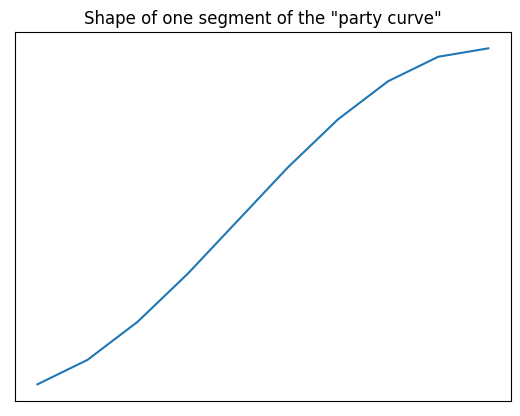

In [11]:
# define step size

b = 10

# create bins

dividers = [np.array([x*np.pi/b,(x+1)*np.pi/b]) for x in range(b)]
bins = [(np.sin(x-np.pi/2)+1)/2 for x in dividers]

plt.plot([  bins[i][1] for i in range(b) ])
plt.title('Shape of one segment of the "party curve"')
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
# fill bins with songs according to their party_score 

binned_songs = []
for bin in bins:
    in_this_bin = []
    for i,x in zip(track_list.index,track_list.party_score):
        if bin[0] < x and x <= bin[1]:
            in_this_bin.append(i)
    binned_songs.append(in_this_bin)

How often do we need to loop through binned_songs in order to put every song on the playlist?

To answer this find size of the fullest bin:

In [13]:
l = max([len(i) for i in binned_songs])

In [14]:
# create playlist by successively adding songs from binned_songs until all bins are empty (add "fillers" if necessary)  

playlist = [start_song.index[0]] # starts with start_song
for iteration in range(l):
    for elt in binned_songs:
        if not elt: # case no song in bin
            playlist.append("filler")
        else:
            playlist.append(elt[0])
            elt.remove(elt[0])

playlist.append(end_song.index[0]) # add end_song            

__TODO:__ How to deal with fillers? Generate similar songs to previous one (how many, though?), take the one that fits the bin

In [15]:
playlist_without_fillers = [song for song in playlist if type(song) != str]
playlist_df = df.loc[playlist_without_fillers]

In [16]:
playlist_df

,Unnamed: 0,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,party_score
11670,11670,1K89oHPxT4wRg5ocaDLq3J,Starman - Single Mix,David Bowie,43,3nSP0MJ9XyYZjCRowFaUbo,Legacy (Deluxe Edition),2016-11-11,Classic Rock,5BygwTQ3OrbiwVsQhXFHMz,...,-11.054,1,0.0333,0.211000,0.000000,0.3910,0.582,199.787,254720,0.357109
5200,5200,6VCeEqyExn5hfV1dBsGDIm,Fave Thing,Funky Notes,56,0ecADXvGhKIWjKDwX37Aox,Fave Thing,2019-11-01,Jazz Vibes,37i9dQZF1DX0SM0LYsmbMT,...,-13.170,0,0.2740,0.212000,0.000528,0.1390,0.233,169.471,184000,0.458732
13841,13841,5F8WPtrurLmNE3tv6Sm14m,I Wanna Be Somebody,W.A.S.P.,3,5ve6MqQrbyQyf4vFUDar6G,WASP,1984,’80s Hard Rock,37i9dQZF1DX68H8ZujdnN7,...,-7.051,0,0.0505,0.000810,0.000000,0.2630,0.478,164.124,223533,0.569051
19730,19730,0psbBdxOb3A8WMuG3ludUw,Gumbo,Jay Rock,33,43RbK79xoUGDLRlWyKppKM,Gumbo,2015-07-01,Urban/Trap - Contemporary RAP,5CK0fshHcik1vWyeCc0zat,...,-7.758,1,0.0863,0.238000,0.000033,0.1890,0.235,100.975,221309,0.716324
21372,21372,76LIYXBETh3PyHoNUufycb,The Floor,Johnny Gill,13,7yaVJMGC31c2JYyX0izpjL,Provocative,1993-01-01,New Jack City,6RLvj5OnEuPzI1P02KwnzK,...,-4.646,1,0.0385,0.002450,0.089700,0.1570,0.388,115.577,312800,0.845119
26947,26947,22M8SqgMTYaDQWV0TeW6Ab,FIVEg,Dave Spoon,4,5zTbjAiz1D2zWzVtSHT8TB,FIVEg,2011-01-12,Selected House,2JPzPB9jnvJLAYtmCbvZy8,...,-12.128,1,0.0797,0.026200,0.958000,0.1100,0.122,127.990,431274,0.647850
2475,2475,7wFybC8jBH3zE139OpCtpG,Lost in the Fire,Gesaffelstein,20,3gXi45Aift9hCoB6lvuVJb,Lost in the Fire,2019,Electropop 2019,4Bi8VLtaSu0JILliif8lH6,...,-12.159,1,0.0359,0.086300,0.001330,0.1170,0.176,101.004,202093,0.684261
18456,18456,2cnKEkpVUSV4wnjQiTWfH6,Escápate Conmigo,Wisin,11,5uWJP1QRmJemAFD3JH2LOG,Escápate Conmigo,2017-03-31,VidaLoca - Latin / Raggaeton / Hip Hop ©,7EPbNmUW9nkRplDLSN9te4,...,-3.181,0,0.0599,0.024500,0.000045,0.0853,0.754,92.028,232787,0.832620
26872,26872,3LGxef3inmn5jMLGDz9lqw,Send My Love (To Your New Lover),Adele,60,7xX2GJWXXgIwamzN2vxXy0,Send My Love (To Your New Lover),2016-05-16,EDM/POP,6gHk5RFrnALbDNJdaXKivi,...,-8.390,0,0.1030,0.041500,0.000003,0.1700,0.562,164.023,223080,0.616874
21515,21515,6BxiFSFVzviEqe2eIaruLV,Top of the World (feat. Mase),Brandy,50,1Co6e9ag1gRKcWdG7xKcCi,Never Say Never,1998-05-29,Ultimate Throwbacks Collection,1dsaMvnC1hXPCNGC4aVtjj,...,-5.739,1,0.1320,0.003010,0.031400,0.1050,0.855,98.015,281507,0.750560


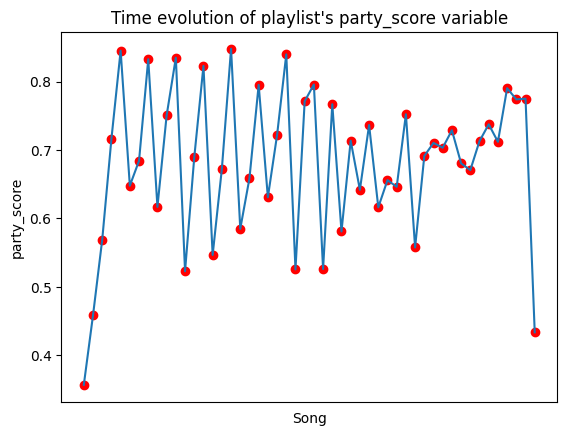

In [18]:
playlist_scores = list(playlist_df.party_score)
plt.plot(playlist_scores)
plt.scatter(range(len(playlist_scores)),playlist_scores,c="red")
plt.xticks([])
plt.xlabel("Song")
plt.ylabel("party_score")
plt.title("Time evolution of playlist's party_score variable")
plt.show()

Of course, other shapes are also possible (could also bin songs in the descending part of sin-curve etc...)